In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from esn_module import esn

from echo_state_tests import gen_in_out_one_in_subs

from echo_state_tests import test_XOR

In [213]:
ESN = [esn(sigm_w=1.,mu_act_target=np.random.random_sample((1000))*(.1-(.1))+(.1),sigm_act_target=0.25*np.ones((1000))),
esn(sigm_w=1.,mu_act_target=np.random.random_sample((1000))*(.1-(.1))+(.1),sigm_act_target=0.8*np.random.random_sample((1000))+0.1)]

l1 = [np.linalg.eigvals(ESN[k].W_gain()) for k in range(2)]

In [214]:
u_in,u_out = gen_in_out_one_in_subs(20000,5)

In [215]:
results = []

for k in range(2):
    results.append(ESN[k].run_hom_adapt_weight_mean_field(u_in,
                                            return_reservoir_rec=True,
                                            return_gain_rec=True,
                                            return_bias_rec=True,
                                            return_sigm_act_target_rec=True,
                                            return_mu_y_rec=True,
                                            return_sigm_y_rec=True,
                                            return_v_rec=True,
                                            show_progress=True,
                                            subsample_rec=10))

y = [results[k][0] for k in range(2)]
b = [results[k][1] for k in range(2)]
a = [results[k][2] for k in range(2)]
sigm_t = [results[k][3] for k in range(2)]
mu_y = [results[k][4] for k in range(2)]
sigm_y = [results[k][5] for k in range(2)]
v = [results[k][6] for k in range(2)]

100%|██████████| 19999/19999 [00:39<00:00, 506.89it/s]


In [216]:
l2 = [np.linalg.eigvals(ESN[k].W_gain()) for k in range(2)]

In [217]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

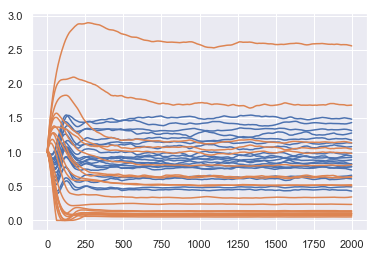

In [218]:
for k in range(2):
    plt.plot(a[k][:,:20],c=colors[k])

plt.show()

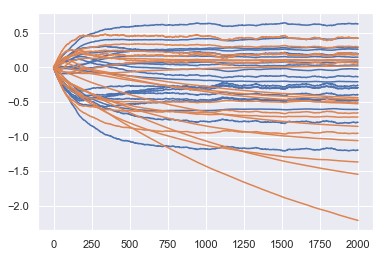

In [219]:
for k in range(2):
    plt.plot(b[k][:,:20],c=colors[k])

plt.show()

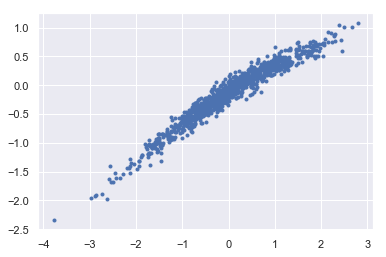

In [220]:
plt.plot(ESN[0].w_in,b[0][-1,:],'.')
plt.show()

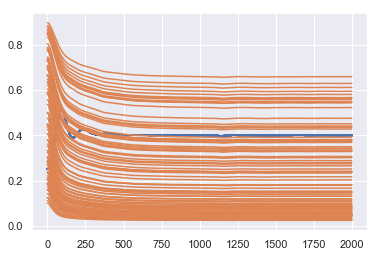

In [221]:
for k in range(2):
    plt.plot(sigm_t[k][:,:100],c=colors[k])

plt.show()

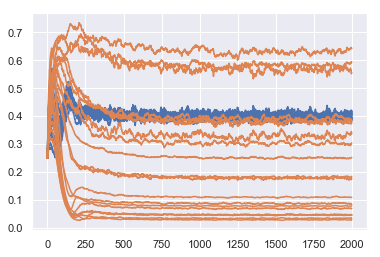

In [222]:
for k in range(2):
    plt.plot(sigm_y[k][:,:20],c=colors[k])
plt.show()

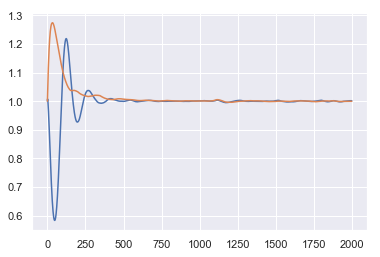

In [223]:
for k in range(2):
    plt.plot(v[k],c=colors[k])
#plt.ylim([0.,2.])
plt.show()

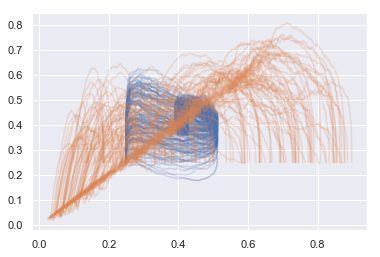

In [224]:
for l in range(2):
    for k in range(150):
        plt.plot(sigm_t[l][-5000:,k],sigm_y[l][-5000:,k],c=colors[l],alpha=0.2)
plt.show()

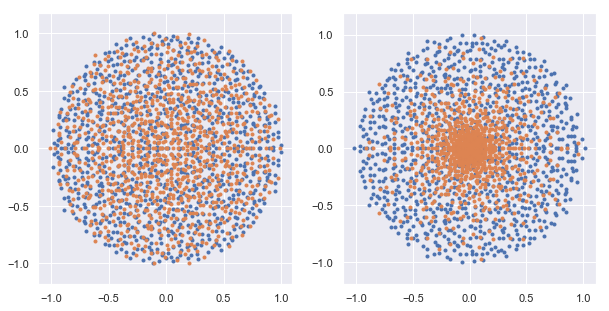

In [225]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

for k in range(2):
    ax[k].plot(l1[k].real,l1[k].imag,'.',c=colors[0])
    ax[k].plot(l2[k].real,l2[k].imag,'.',c=colors[1])

ax[0].axis("equal")
ax[1].axis("equal")

plt.show()

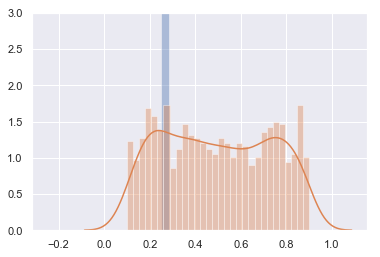

In [226]:
for k in range(2):
    sns.distplot(sigm_t[k][0,:],bins=30)

plt.ylim([0.,3.])

plt.show()

In [227]:
l1abs = [np.abs(l1[k]) for k in range(2)]
l2abs = [np.abs(l2[k]) for k in range(2)]

h1 = [np.histogram(l1abs[k]) for k in range(2)]
h2 = [np.histogram(l2abs[k]) for k in range(2)]

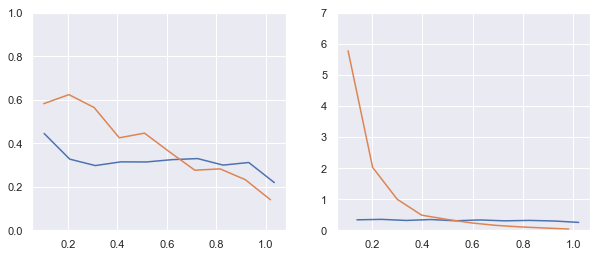

In [228]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

for k in range(2):
    ax[k].plot(h1[k][1][1:],h1[k][0]/(ESN[k].N*np.pi*(h1[k][1][1:]**2.-h1[k][1][:-1]**2.)))
    ax[k].plot(h2[k][1][1:],h2[k][0]/(ESN[k].N*np.pi*(h2[k][1][1:]**2.-h2[k][1][:-1]**2.)))
    
ax[0].set_ylim([0.,1.])
ax[1].set_ylim([0.,7.])
plt.show()

In [229]:
u_in_learn, u_out_learn = gen_in_out_one_in_subs(5000,5)

for k in range(2):
    ESN[k].learn_w_out(u_in_learn,u_out_learn)

ESN_pre_adapt.learn_w_out(u_in_learn,u_out_learn)

100%|██████████| 4999/4999 [00:00<00:00, 6897.07it/s]


In [230]:
u_in_test,u_out_test = gen_in_out_one_in_subs(5000,5)

u_out_predict = [ESN[k].predict_data(u_in_test) for k in range(2)]

u_out_predict_pre_learn = ESN_pre_adapt.predict_data(u_in_test)

100%|██████████| 4999/4999 [00:00<00:00, 6821.31it/s]


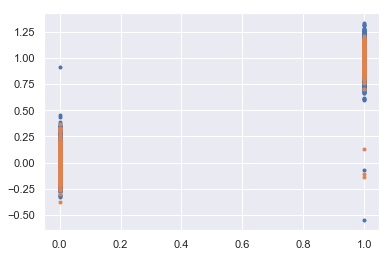

In [231]:
plt.plot(u_out_test,u_out_predict[0],'.')
plt.plot(u_out_test,u_out_predict_pre_learn,'.')
plt.show()

In [232]:
r1 = np.corrcoef(u_out_test,u_out_predict[0])
r2 = np.corrcoef(u_out_test,u_out_predict_pre_learn)
print(r1[1,0]**2.)
print(r2[1,0]**2.)

0.9518746211796776
0.9844827000258323


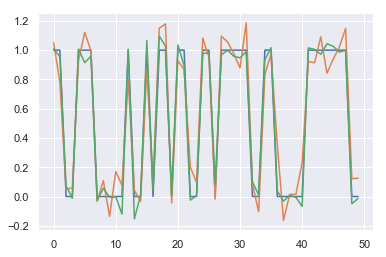

In [233]:
plt.plot(u_out_test[-50:])
plt.plot(u_out_predict[0][-50:])
plt.plot(u_out_predict_pre_learn[-50:])
plt.show()

In [234]:
dat_xor_single_input = np.load("../data/max_lyap_sweep/xor_lyap_esp_2.npz")
dat_xor_indep_input = np.load("../data/max_lyap_sweep/xor_mc_esp_lyap.npz")

In [235]:
dat_xor_single_input.files

['params_list',
 'std_act_target_sweep_range',
 'mem_cap_xor_list',
 'max_l_list',
 'gain_list',
 'std_in_sweep_range',
 'echo_state_prop_list']

In [236]:
dat_xor_indep_input.files

['max_l_list',
 'gain_list',
 'mem_cap_list',
 'mem_cap_xor_list',
 'std_act_target_sweep_range',
 'params_list',
 'W',
 'echo_state_prop_list',
 'std_in_sweep_range',
 'trail_av_hom_error_list']

In [237]:
sigm_t = dat_xor_single_input["std_act_target_sweep_range"]
sigm_e = dat_xor_single_input["std_in_sweep_range"]

xor_single_input = dat_xor_single_input["mem_cap_xor_list"]
xor_indep_input = dat_xor_indep_input["mem_cap_xor_list"]

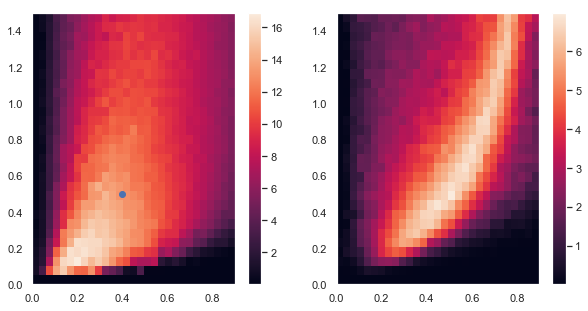

In [238]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
pc1 = ax[0].pcolormesh(sigm_t,sigm_e,xor_single_input)
pc2 = ax[1].pcolormesh(sigm_t,sigm_e,xor_indep_input)
plt.colorbar(pc1,ax=ax[0])
plt.colorbar(pc2,ax=ax[1])
ax[0].scatter([ESN[0].sigm_act_target[0]],[u_in.std()])
plt.show()

In [239]:
ind_t = np.argmin((sigm_t-ESN[0].sigm_act_target[0])**2.)

In [240]:
ind_e = np.argmin((sigm_e-u_in.std())**2.)

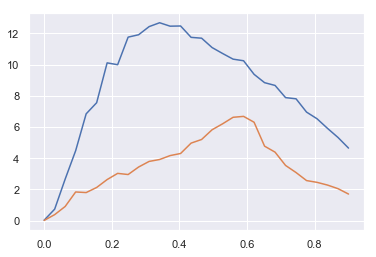

In [241]:
plt.plot(sigm_t,xor_single_input[ind_t,:])
plt.plot(sigm_t,xor_indep_input[ind_t,:])
plt.show()

In [242]:
dat_xor_single_input["params_list"][19,15].keys()

dict_keys(['', 'data_dim_in', 'alpha', 'cf_w_in', 'bias', 'eps_trail_av_sigm_act', 'mu_act_target', 'eps_gain', 'eps_trail_av_mu_ext', 'eps_trail_av_mu_recurr', 'reg_fact', 'eps_trail_av_sigm_ext', 'cf', 'data_dim_out', 'sigm_w', 'gain', 'eps_trail_av_act', 'eps_trail_av_sigm_recurr', 'eps_bias', 'sigm_w_in', 'noise_level', 'sigm_act_target'])

In [243]:
ESN[0].sigm_act_target[0]

0.3995957096258433

In [244]:
u_in.std()

0.499999277499478

In [245]:
ESN[0].mu_act_target.std()

1.3877787807814457e-17

In [246]:
dat_xor_single_input["params_list"][ind_e,ind_t]["mu_act_target"].std()

0.010147737906318677

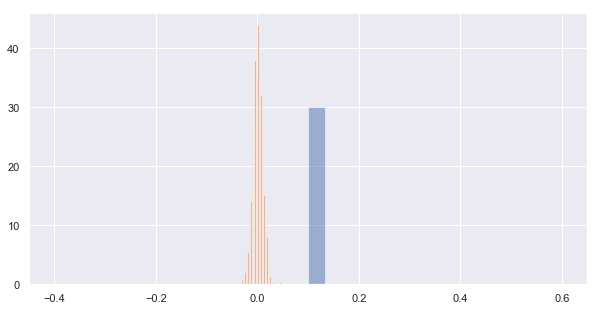

In [247]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.hist(ESN[0].mu_act_target,alpha=0.5,bins=30,density=True)
ax.hist(dat_xor_single_input["params_list"][ind_e,ind_t]['mu_act_target'],alpha=0.5,bins=30,density=True)
#ax.hist(ESN_pre_adapt.mu_act_target,alpha=0.5,bins=30,density=True)
plt.show()

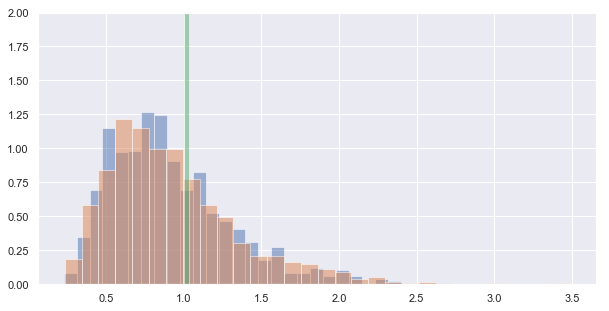

In [248]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(ESN[0].gain,alpha=0.5,bins=30,density=True)
ax.hist(dat_xor_single_input["gain_list"][ind_e,ind_t,:],alpha=0.5,bins=30,density=True)
ax.hist(ESN_pre_adapt.gain,alpha=0.5,bins=30,density=True)
ax.set_ylim([0.,2.])
plt.show()

In [252]:
MC_list, MC = test_XOR(ESN[0],20,5000,0.01,10,.5)
MC_list_var_targ, MC_var_targ = test_XOR(ESN[1],20,5000,0.01,10,.5)

ESN_pre_adapt = esn()

MC_list_pre_adapt, MC_pre_adapt = test_XOR(ESN_pre_adapt,20,5000,0.01,10,.5)

100%|██████████| 20/20 [00:33<00:00,  1.71s/it]


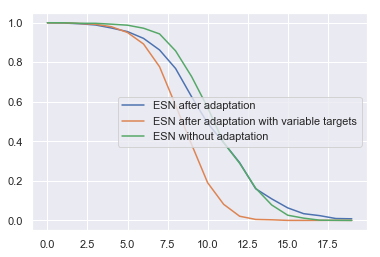

In [253]:
plt.plot(MC_list,label="ESN after adaptation")
plt.plot(MC_list_var_targ,label="ESN after adaptation with variable targets")
plt.plot(MC_list_pre_adapt,label="ESN without adaptation")
plt.legend()
plt.show()

In [254]:
print(MC)
print(MC_var_targ)
print(MC_pre_adapt)

10.663694062960024
8.848934585057323
11.000183109729926
